# Integration of SVM and MVO 

This notebook computes and visualizes the results of the computational experiments

In [1]:
import numpy as np
from pandas.tseries.offsets import Day, MonthBegin
pth = 'cache/Experiments/'
local_path = 'cache/Local Experiments/'
cache_path = 'cache/'
img_path = "Images/"

from python.packages import *
from python.analysis_tools import *
import pickle
%matplotlib inline
dpi_setting = 150

In [2]:
## Import Monthly Returns
rets = pd.read_pickle(cache_path + "RETS.pkl")
## Import feature vectors
wrds_svm = pd.read_pickle(cache_path + "WRDS_ASOF.pkl")
## Import Daily Prices
Prices = pd.read_pickle(cache_path + "Daily_Prices.pkl")
## Get the trade dates
StockDates = wrds_svm.reset_index().loc[:, ['Date', 'MonthStart', 'MonthEnd']].drop_duplicates()

#risk free rate data
FF_RiskFree = pd.read_csv(cache_path + "F-F_Research_Data_Factors.CSV")
FF_RiskFree.Date = pd.to_datetime(FF_RiskFree['Date'], format='%Y%m', errors='coerce')
FF_RiskFree.index = FF_RiskFree.Date
FF_RiskFree.drop(FF_RiskFree.columns[0:4], axis=1, inplace = True)


In [3]:
daily_rets = Prices.pct_change() + 1
new_index = daily_rets.index[0:-1] #VERY IMPORTANT
daily_rets.drop(daily_rets.head(1).index,inplace=True)
daily_rets.index = new_index
Prices['StartMonth'] = Prices.index + Day(1) + MonthBegin(-1)
#this calculate the month of the stock returns
daily_rets['StartMonth'] = daily_rets.index + Day(1) + MonthBegin(-1)
# daily_rets[['AAPL', 'StartMonth']].head()
# daily_rets.dropna(inplace = True)
# daily_rets.head()

In [4]:
# daily_portfolio = pd.merge(weights_mvo, daily_rets.reset_index()[['Date', 'StartMonth']], how='left', left_index = True, right_on = 'StartMonth')
# daily_portfolio.index = daily_portfolio.Date
#Rets.index.isin(StockDates.MonthStart.values)
(daily_rets).groupby('StartMonth').prod().iloc[8:].head() - 1

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,
2000-07-01,-0.075030,0.149590,0.194030,-0.043729,-0.105083,-0.184231,-0.018750,-0.034648,-0.424388,0.071684,...,0.040179,-0.041758,0.080448,0.132415,-0.166544,0.005695,0.142562,-0.245399,-0.098253,0.158960
2000-08-01,0.286440,-0.007130,0.565625,0.025185,0.182414,0.552152,-0.058899,0.194307,0.386707,0.076923,...,0.086912,-0.105505,-0.053455,0.119107,0.294014,0.036879,0.014466,0.069129,0.157385,0.062344
2000-09-01,-0.617734,0.412926,0.045908,0.108381,0.204822,-0.171393,0.042857,0.076122,-0.128540,0.072135,...,-0.088809,-0.050227,-0.165289,0.100985,-0.051700,0.108334,-0.003583,-0.057692,0.031381,-0.167840
2000-10-01,-0.154641,-0.102922,-0.125954,0.107287,-0.052148,-0.291667,0.219178,-0.000965,-0.157850,-0.044117,...,-0.005797,0.009461,0.193338,-0.050657,-0.225969,0.006835,-0.001792,-0.440816,-0.016227,-0.055007
2000-11-01,-0.167680,0.107649,-0.192140,0.000000,-0.128641,-0.119748,0.151331,0.002896,0.285714,0.096923,...,-0.185131,0.096384,0.013947,0.023752,-0.406858,-0.030599,0.086176,-0.264868,0.129897,0.007463


In [5]:
from itertools import product
turnovers = ["0_75", "1", "1_25"]
cardinalities  = ["Card01", "Card03", "Card05", "Card07", "Card09"]
card_strings = [r"$K = \lfloor 0.1N \rfloor$", r"$K = \lfloor0.3N\rfloor$", r"$K = \lfloor0.5N \rfloor$", r"$K = \lfloor0.7N \rfloor$", r"$K = \lfloor0.9N \rfloor$"]
turnover_strings = ["$C_0 = 0.75/6$", "$C_0 = 1.00/6$", "$C_0 = 1.25/6$"]

epsilon = 1e-3 #change epsilon to generate different tables

epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3",
                 1e-4:"eps negative 4", 1e-5:"eps negative 5"}


In [27]:
def compare_files(triples, turnovers, cardinalities, local_path, epsilon_folder, label_dict = None, figsize=(8.5,10.5)):
    max_y = 0
    lw = 1
    min_y = 0.8

    svm_weights = {}
    svm_biases = {}

    if label_dict is None:
        label_dict = {}
        for triple in triples:
            label_dict[triple] = str(triple)

    fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                        sharex=True, sharey = True, figsize=figsize)

    if len(cardinalities) == 1:
        axs = np.expand_dims(axs, axis = 0)
    if len(turnovers) == 1:
        axs = np.expand_dims(axs, axis = 1)

    df_cols = []
    #load in the appropriate files
    for i in range(len(cardinalities)):

        df_rows = []
        for j in range(len(turnovers)):
            turnover = turnovers[j]
            card = cardinalities[i]
            #load in benchmarks
            with open(local_path + "Cardinality Portfolios/"+card+"_"+turnover+"no_tlim.pkl",'rb') as fp:
                card_mvo_results = pickle.load(fp)
            with open(local_path + "Standard MVO Portfolios/"+turnover+"no_tlim.pkl",'rb') as fp:
                mvo_results = pickle.load(fp)

            weights_card_mvo  = card_mvo_results[0]
            weights_mvo =  mvo_results[0]

            oot_returns_mvo = (weights_mvo.iloc[:-1]*rets).sum(axis = 1)
            oot_returns_card_mvo = (weights_card_mvo.iloc[:-1]*rets).sum(axis = 1)

            rf = FF_RiskFree[FF_RiskFree.index.isin(oot_returns_mvo.index)]
            rf = rf.RF;

            mvo_wealth = wealth(oot_returns_mvo)
            card_mvo_wealth = wealth(oot_returns_card_mvo)
            mvo_ret_stats = RetStats(oot_returns_mvo, rf/100)
            card_ret_stats = RetStats(oot_returns_card_mvo, rf/100)

            (card_mvo_wealth/mvo_wealth).plot(label = 'Card-MVO', fontsize = 8, ax=axs[i, j], linewidth = lw)

            card_string = card_strings[i]
            turnover_string = turnover_strings[j]

            row_tuples = [(turnover_string, "MVO"), (turnover_string, "Card MVO") ]


            col_tuples =[(card_string, "$\mu$"), (card_string,"$\sigma$"), (card_string,"S.R")]
            col_index = pd.MultiIndex.from_tuples(col_tuples)

            svm_weights[(card, turnover)] = {}
            svm_biases[(card, turnover)] = {}
            ret_stats = [mvo_ret_stats, card_ret_stats]
            for triple in triples:
                prefix, col, name = triple
                with open(local_path + epsilon_folder+"/"+prefix+ card + col +turnover+name+".pkl", 'rb') as fp:
                    results = pickle.load(fp)
                    #weights_adm, oot_returns_adm, market_adm, wis_adm_1, bias_adm_1, soln_mods_adm = new_adm_results
                weights = results[0]
                svm_weights[(card, turnover)][triple] = results[3]
                svm_biases[(card, turnover)][triple] = np.array(results[4])
                oot_returns = (weights.iloc[:-1]*rets).sum(axis = 1)
                wealth_pair = wealth(oot_returns)
                (wealth_pair/mvo_wealth).plot(label = label_dict[triple], fontsize = 8, ax=axs[i, j], linewidth = lw)

                row_tuples.append((turnover_string, label_dict[triple]))

                ret_stats.append(RetStats(oot_returns, rf/100))
                max_ = max(np.max((card_mvo_wealth/mvo_wealth)), np.max((wealth_pair/mvo_wealth)))
                if max_ > max_y:
                    max_y = max_

            axs[i, j].set_title(card_string + ", " + turnover_string, fontsize = 8)

            row_index = pd.MultiIndex.from_tuples(row_tuples)

            out = pd.DataFrame(ret_stats, index = row_index, columns = col_index)

            df_rows.append(out)

        column = pd.concat(df_rows)
        df_cols.append(column)

    axs[len(cardinalities)-1, 0].legend(loc='upper center',
             bbox_to_anchor=(0.3, -0.2),
                 fancybox=False,
                 shadow=False, ncol=3,
                 fontsize = 8)
    for ax in axs:
        for sub_ax in ax:
            sub_ax.yaxis.set_tick_params(which='minor', bottom=False)
            sub_ax.set_yticks([min_y+i*0.2 for i in range(2+int((max_y - min_y)/0.2))])
            sub_ax.grid()
            sub_ax.set_xlabel("Trade Date",fontsize = 8)
    # fig.supxlabel('Trade Date',fontsize = 8)
    fig.supylabel("Cumulative Relative Wealth",fontsize = 8)
    #plt.tight_layout()
    fig.subplots_adjust(wspace = 0.05, hspace=0.4)

    return svm_weights, svm_biases, pd.concat(df_cols, axis = 1)
    #plt.setp(axs, yticks = [i*0.2 for i in range(2+int(max_y/0.2))])

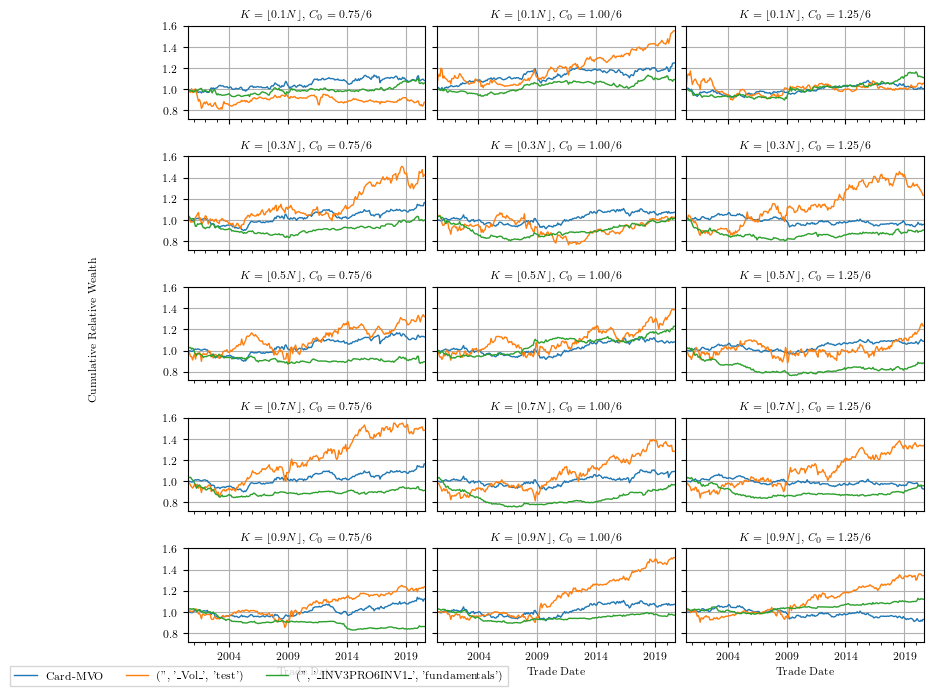

In [38]:
turnovers = ["0_75", "1", "1_25"]
cardinalities  = ["Card01", "Card03", "Card05", "Card07", "Card09"]
figsize = (9.5, 8)
epsilon_folder = epsilons_desc[epsilon] #"eps negative 3"

triples = [('', "_Vol_", "test"),
           ('', "_INV3PRO6INV1_", "fundamentals")
           #('', "_Vol_", "no_tlim"),
           # ('padm', "_Vol_", "final"),
           # ('padm', "_Vol_", "final_lightreg"),
           # ('padm', "_Vol_", "final_linearreg"),
           # ('padm', "_Vol_", "balanced"),
           # ('padm', "_Vol_", "balanced2"),
           # ('padm', "_Vol_", "balanced3"),
           # ('padm', "_Vol_", "balanced4"),
           # ('padm', "_Vol_", "balanced5"),
           # ('padm', "_Vol_", "balanced6"),
           # #('padm', "_INV3PRO6INV1_", "final_reg"),
           # ('padm', "_INV3PRO6INV1_", "final_lightreg"),
           # #('padm', "_INV3PRO6INV1_", "no_tlim"),
           # ('padm', "_INV3PRO6INV1_", "final")
           ]
           # ('padm', "_Vol_", "final_lightreg"),
           # ('padm', "_Vol_", "final_linearreg"),
           # ('padm', "_Vol_", "balanced"),
           # ('padm', "_Vol_", "balanced2"),
           # ('padm', "_Vol_", "balanced3"),
           # ('padm', "_Vol_", "balanced4"),
           # ('padm', "_Vol_", "balanced5")]
svm_weights, svm_biases, df_stats = compare_files(triples, turnovers, cardinalities, local_path, epsilon_folder, label_dict = None, figsize = figsize)


In [39]:
df_stats

$K = \lfloor 0.1N \rfloor$  \
                                                                           $\mu$   
$C_0 = 0.75/6$ MVO                                                         11.9%   
               Card MVO                                                    12.3%   
               ('', '_Vol_', 'test')                                       11.3%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                      12.2%   
$C_0 = 1.00/6$ MVO                                                         11.2%   
               Card MVO                                                    12.3%   
               ('', '_Vol_', 'test')                                       13.4%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                      11.6%   
$C_0 = 1.25/6$ MVO                                                         10.9%   
               Card MVO                                                    10.9%   
               ('', '_Vol_', 'test')                                       11.2%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                      11.4%   

                                                                       \
                                                      $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                       11.5%   1.03   
               Card MVO                                  11.3%   1.09   
               ('', '_Vol_', 'test')                     12.2%  0.928   
               ('', '_INV3PRO6INV1_', 'fundamentals')    12.5%  0.976   
$C_0 = 1.00/6$ MVO                                       11.3%  0.988   
               Card MVO                                  12.0%   1.02   
               ('', '_Vol_', 'test')                     11.5%   1.16   
               ('', '_INV3PRO6INV1_', 'fundamentals')    11.8%  0.989   
$C_0 = 1.25/6$ MVO                                       11.2%  0.976   
               Card MVO                                  10.7%   1.03   
               ('', '_Vol_', 'test')                     10.2%    1.1   
               ('', '_INV3PRO6INV1_', 'fundamentals')    11.4%    1.0   

                                                      $K = \lfloor0.3N\rfloor$  \
                                                                         $\mu$   
$C_0 = 0.75/6$ MVO                                                       11.9%   
               Card MVO                                                  12.7%   
               ('', '_Vol_', 'test')                                     13.7%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                    11.9%   
$C_0 = 1.00/6$ MVO                                                       11.2%   
               Card MVO                                                  11.6%   
               ('', '_Vol_', 'test')                                     11.3%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                    11.3%   
$C_0 = 1.25/6$ MVO                                                       10.9%   
               Card MVO                                                  10.7%   
               ('', '_Vol_', 'test')                                     12.0%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                    10.4%   

                                                                       \
                                                      $\sigma$    S.R   
$C_0 = 0.75/6$ MVO                                       11.5%   1.03   
               Card MVO                                  10.9%   1.16   
               ('', '_Vol_', 'test')                     10.9%   1.26   
               ('', '_INV3PRO6INV1_', 'fundamentals')    12.2%  0.979   
$C_0 = 1.00/6$ MVO                                       11.3%  0.988   
               Card MVO                                  10.8%   1.07   
               ('', '_Vol_', 'test')                     13.8%  0.823   
               ('', '_INV3PRO6INV1_', 'fundament

In [42]:
print(df_stats)

                                                      $K = \lfloor 0.1N \rfloor$  \
                                                                           $\mu$   
$C_0 = 0.75/6$ MVO                                                         11.9%   
               Card MVO                                                    12.3%   
               ('', '_Vol_', 'test')                                       11.3%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                      12.2%   
$C_0 = 1.00/6$ MVO                                                         11.2%   
               Card MVO                                                    12.3%   
               ('', '_Vol_', 'test')                                       13.4%   
               ('', '_INV3PRO6INV1_', 'fundamentals')                      11.6%   
$C_0 = 1.25/6$ MVO                                                         10.9%   
               Card MVO                                                    1

In [41]:
df_stats.to_csv("out_full2.csv")

PermissionError: [Errno 13] Permission denied: 'out_full2.csv'

In [32]:
svm_biases[(card, turnover)]

NameError: name 'card' is not defined

In [208]:
print(df.median())

      _Vol_  test          0.057071
             no_tlim       0.062436
padm  _Vol_  balanced      0.012568
             balanced2     0.052551
             balanced3    15.020837
             balanced6     0.014125
dtype: float64


      _Vol_  test         0.000000
             no_tlim      0.000000
padm  _Vol_  balanced     0.043485
             balanced2    0.019417
             balanced3    0.000356
             balanced6    0.039949
dtype: float64
      _Vol_  test         0.000000
             no_tlim      0.000000
padm  _Vol_  balanced     0.010104
             balanced2    0.009615
             balanced3    0.000046
             balanced6    0.015708
dtype: float64
      _Vol_  test         0.000000e+00
             no_tlim      0.000000e+00
padm  _Vol_  balanced     2.822993e-09
             balanced2    5.438340e-04
             balanced3    1.142835e-05
             balanced6    1.981752e-08
dtype: float64
      _Vol_  test         0.013415
             no_tlim      0.015970
padm  _Vol_  balanced     0.078125
             balanced2    0.021790
             balanced3    0.000081
             balanced6    0.073749
dtype: float64
      _Vol_  test         0.017522
             no_tlim      0.016016
padm  

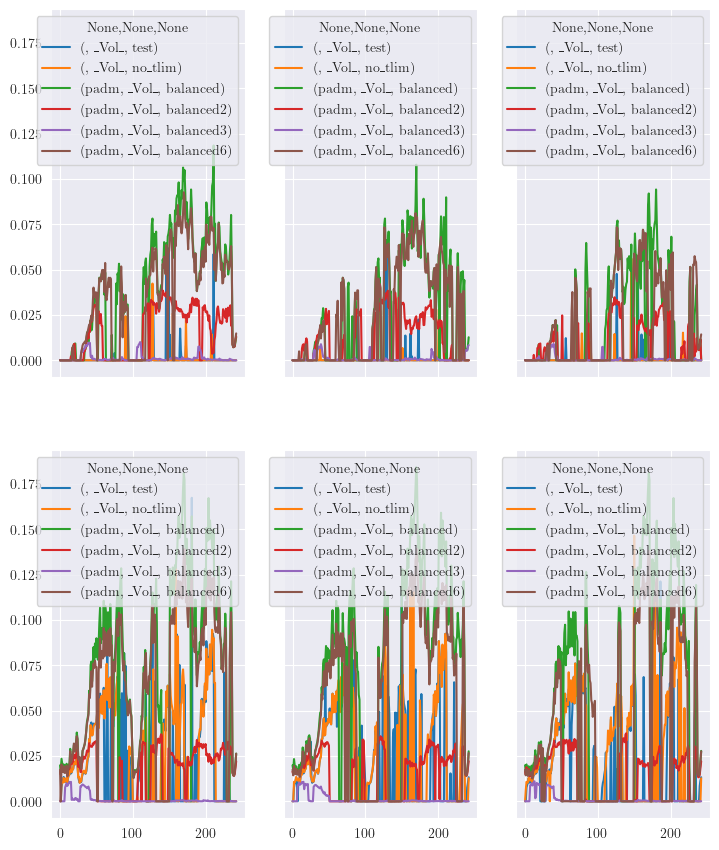

In [210]:
fig, axs = plt.subplots(len(cardinalities), len(turnovers),
                        sharex=True, sharey = True, figsize=(8.5,10.5))
if len(cardinalities) == 1:
    axs = np.expand_dims(axs, axis = 0)
if len(turnovers) == 1:
    axs = np.expand_dims(axs, axis = 1)
#load in the appropriate files
for (i ,j) in product(range(len(cardinalities)), range(len(turnovers))):
    turnover = turnovers[j]
    card = cardinalities[i]
    df = pd.DataFrame({key: value.flatten() for key, value in svm_weights[(card, turnover)].items()})
    # svm_weights_flattened = {key: value.flatten() for key, value in svm_weights[(card, turnover)].items()}
    # thresholds = {key: (epsilon - svm_biases[(card, turnover)][key].flatten())/svm_weights_flattened[key] for key, value in svm_weights[(card, turnover)].items()}
    # df = pd.DataFrame(thresholds)
    print(df.median())
    df.plot(ax = axs[i, j])

({('Card01',
   '0_75'): {('', '_Vol_', 'no_tlim'): array([[0.00000000e+00],
          [4.68004430e-05],
          [1.62339717e-04],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [3.22242656e-12],
          [2.62384165e-13],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],

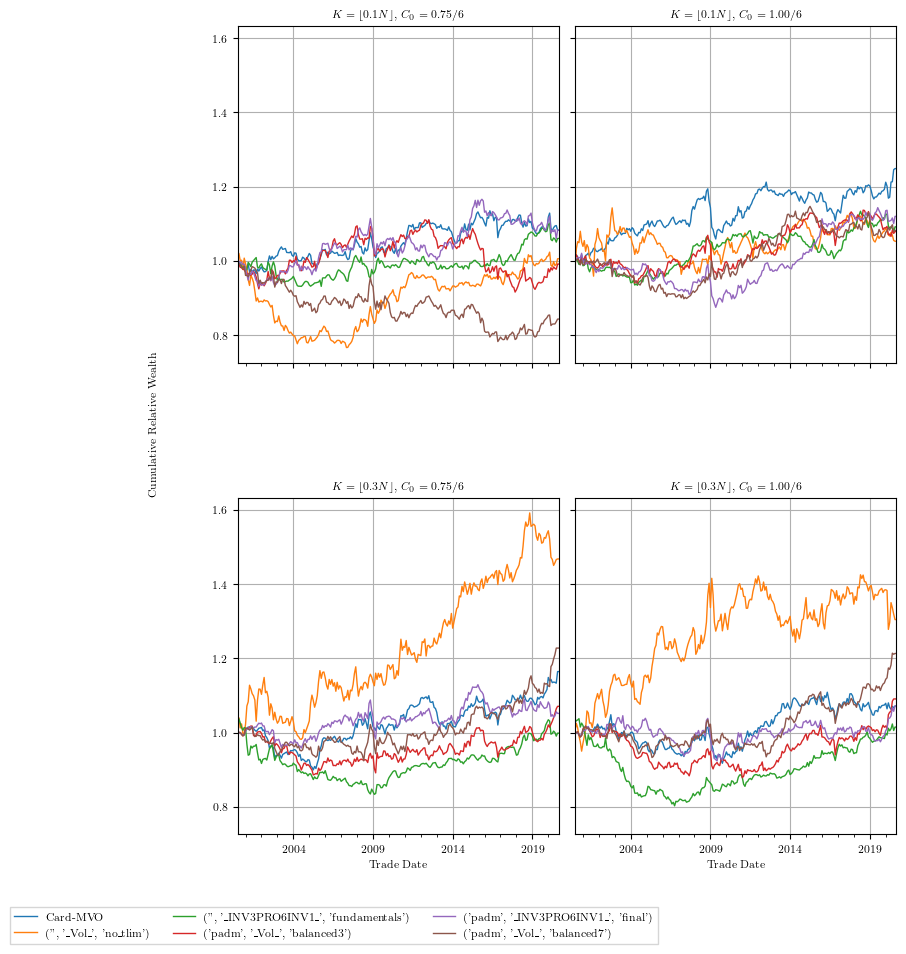

In [43]:
turnovers = ["0_75", "1"]
cardinalities  = ["Card01", "Card03"]
epsilon_folder = "eps negative 3"

triples = [#('', "_Vol_", "test"),
           ('', "_Vol_", "no_tlim"),
           ('', "_INV3PRO6INV1_", "fundamentals"),
           ('padm', '_Vol_', 'balanced3'),
           ('padm', '_INV3PRO6INV1_', 'final'),
           ('padm', '_Vol_', 'balanced7')
            ]
compare_files(triples, turnovers, cardinalities, local_path, epsilon_folder, label_dict = None)

#RetStats(oot_returns_adm_test, rf/100)

({('Card01',
   '0_75'): {('padm',
    '_INV3PRO6INV1_',
    'final_reg'): array([[5.11731084e-12, 1.29247394e-10, 5.26314204e-08],
          [1.66615090e-11, 4.01886438e-10, 5.26293013e-08],
          [3.26927503e-13, 3.96557887e-12, 7.15504580e-16],
          [3.27382469e-13, 6.64310490e-12, 1.22266766e-15],
          [9.16212139e-13, 4.79820713e-12, 4.60931750e-15],
          [1.58406831e-12, 9.16715174e-12, 1.11162876e-14],
          [6.97225595e-13, 4.30715255e-12, 9.26530322e-15],
          [1.74317392e-13, 1.87826972e-11, 7.86378652e-16],
          [2.14817659e-12, 1.61199114e-11, 1.37227262e-14],
          [2.38075269e-13, 7.65320809e-12, 8.29693536e-16],
          [9.50369154e-13, 3.37464668e-11, 1.91954707e-15],
          [5.15553126e-13, 1.18411105e-11, 9.57400895e-16],
          [1.02310065e-13, 1.05554473e-12, 1.76758704e-16],
          [4.59462769e-14, 5.40553618e-13, 6.82233234e-17],
          [1.20574971e-11, 2.58641265e-10, 1.64329759e-14],
          [2.23649206e-13, 8

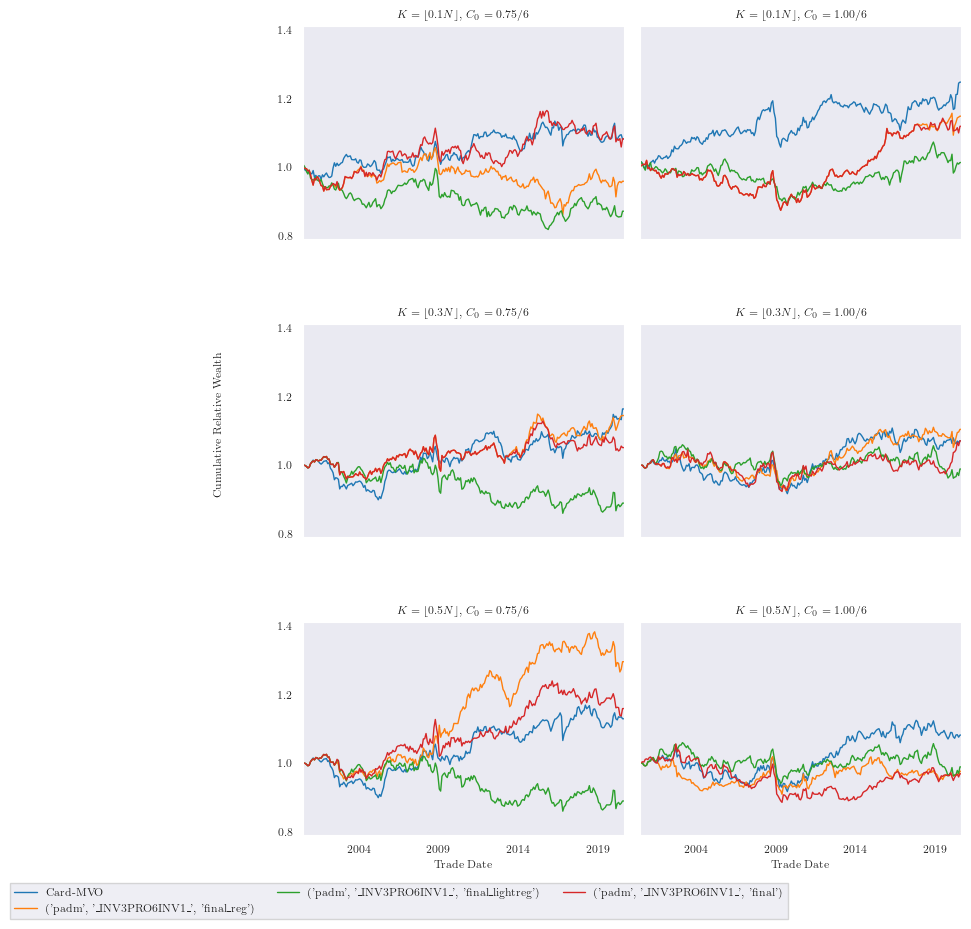

In [223]:

triples = [#('', "_Vol_", "test"),
           #('', "_Vol_", "no_tlim"),
           ('padm', "_INV3PRO6INV1_", "final_reg"),
            ('padm', "_INV3PRO6INV1_", "final_lightreg"),
           #('padm', "_INV3PRO6INV1_", "no_tlim"),
           ('padm', "_INV3PRO6INV1_", "final")]
compare_files(triples, turnovers, cardinalities, local_path, epsilon_folder, label_dict = None)

# Making Latex Tables

In [26]:
def RetStats(returns, rf=None, geomean=True):
    """Assumes returns is a pandas Series"""
    if rf is None:
        returns_rf = returns
    else:
        returns_rf = returns - rf
    P = 12
    P05 = P ** 0.5

    if geomean:
        mean = gmean(1 + returns_rf) - 1
    else:
        mean = returns_rf.mean()
    return "{:.1%}".format(P * mean), "{:.1%}".format(P05 * returns_rf[returns_rf < 0].std()), "{0:.3}".format(P * mean / (P05 * returns_rf[returns_rf < 0].std()))

In [ ]:
for (turnover, card) in product(turnovers, cardinalities):

    with open(local_path + "Cardinality Portfolios/"+card+"_"+turnover+"no_tlim.pkl",'rb') as fp:
        card_mvo_results = pickle.load(fp)
    with open(local_path + "Standard MVO Portfolios/"+turnover+"no_tlim.pkl",'rb') as fp:
        mvo_results = pickle.load(fp)
    # with open(pth + "svm_oot_results_turnover0_75by6.pkl", 'rb') as fp:
    #   svm_results = pickle.load(fp)
    with open(local_path + epsilons_desc[epsilon] + "/" + card + "_Vol_" +turnover + "no_tlim.pkl", 'rb') as fp:
        svm_results = pickle.load(fp)
    with open(local_path + epsilons_desc[epsilon] + "/" + "padm" +card+ cols +turnover + name + ".pkl", 'rb') as fp:
        adm_results = pickle.load(fp)

#     with open(local_path + epsilons_desc[epsilon] + "/" + "padm" +card+ "_VolINV3_" +turnover + "no_neg.pkl", 'rb') as fp:
#         adm_results2 = pickle.load(fp)
    weights_card_mvo, oot_returns_card_mvo, market_card_mvo, wis_card_mvo, bias_card_mvo, soln_mods_card_mvo = card_mvo_results
    weights_mvo, oot_returns_mvo, market_mvo, wis_mvo, bias_mvo, soln_mods_mvo = mvo_results
    weights_svm, oot_returns_svm, market_svm, wis_svm, bias_svm, soln_mods_svm = svm_results
    weights_adm, oot_returns_adm, market_adm, wis_adm, bias_adm, soln_mods_adm, times = adm_results
    
    

In [ ]:
U = np.max(np.abs(np.max(wis_adm, axis = 1)) + np.abs(bias_adm))

bigM = 0
def padm_data_treatment(Y):
    # Y['Momentum'] = wrds_tics.Momentum
    #restrict the wharton research data to the columns of interest
    Y_ = (Y.rank(axis = 0)/(len(Y))+1)
    Y_ =  (Y_ - Y_.mean(axis=0))/(Y_.std(axis=0)) #scale the features
    return Y_

for prd in rets.index.to_list()[:T]:
    
    forecasts = pd.read_pickle('cache/Forecasts.pkl')
    
    cov_, mean_ = forecasts[prd]
    N = len(mean_)
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    cols =  ['INV3', 'PRO6', 'INV1'] 
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation
    
    Y = padm_data_treatment(Y)
    
    largest_norm = Y.abs().sum(axis = 1).max()
    new_bigM = largest_norm*U + U
    if new_bigM > bigM:
        bigM = new_bigM